## Query AIP Gaia Archive to retrieve effective temperatures derived in StarHorse

Instruction for the TAP interface can be found [here](https://gaia.aip.de/cms/documentation/tap-interface/). 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyvo as vo

# init tap service
tap_service = vo.dal.TAPService('https://gaia.aip.de/tap')

# optional: use your API token to use your account
vo.utils.http.session.headers['Authorization'] = 'Token xxx'

In the appendix of [this paper](https://www.aanda.org/articles/aa/pdf/2019/08/aa35765-19.pdf) are some examples on how to query StarHorse. `query_starhorse` is adopted from that page.

In [8]:
def query_starhorse(l):
    """Query StarHorse Teff with uncertainties.
    This would be faster if I knew how to push
    an entire list of IDs instead of one ID at
    a time.
    
    Parameters:
    -----------
    l : list of str
        Gaia IDs
        
    Return:
    -------
    Dataframe with teff16, teff50,
    teff84, and source_id columns.
    """
    
    #Query AIP Gaia Archive
    jobs = []
    for gaiaid in l:
        sql = ("SELECT TOP 50 s.teff16, s.teff50, s.teff84, s.source_id "
               "FROM gdr2_contrib.starhorse AS s "
               "WHERE s.source_id = {} "
               "AND s.sh_gaiaflag LIKE '000' "
               "AND s.sh_outflag like '00000'".format(gaiaid))
       # print(sql)

        job = tap_service.run_sync(sql)
        jobs.append(job)

    # Convert results to a table
    result = pd.DataFrame()
    for job in jobs:
        t= job.to_table().to_pandas()
        result = pd.concat([result,t])
    print("{} good Teff results out of {}.".format(result.shape[0],len(l)))
    return result


def merge_results(df, result):
    """Merge input and output table from query."""
    
    #adopt the larger uncertainty for e_Teff:
    result["difflow"]=result.teff50-result.teff16
    result["diffhig"]=result.teff84-result.teff50
    result["e_Teff_StarHorse"] = result.apply(lambda x: max(x.difflow, x.diffhig), axis=1)
    
    # Rename and merge
    nresult = result.rename(index=str, columns={"teff50":"Teff_StarHorse", "source_id":"source_id_Gaia"})
    tom = nresult[["source_id_Gaia", "Teff_StarHorse", "e_Teff_StarHorse"]]
    newdf = df.merge(tom, how="left", on="source_id_Gaia")
    
    return newdf
   

# Now mix StarHorse temperatures to all cluster tables

Running hyades cluster


116 good Teff results out of 537.
hyades done.

Running ngc2168 cluster
32 good Teff results out of 157.
ngc2168 done.

Running pleiades cluster
387 good Teff results out of 891.
pleiades done.

Running praesepe cluster
495 good Teff results out of 1107.
praesepe done.

Running ngc2682 cluster
874 good Teff results out of 1001.
ngc2682 done.

Running ngc6774 cluster
9 good Teff results out of 72.
ngc6774 done.



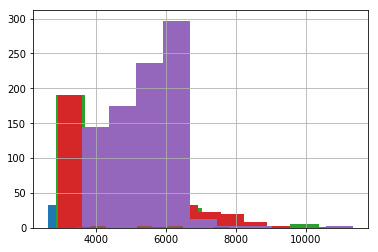

In [9]:
for C in ["hyades","ngc2168","pleiades","praesepe","ngc2682","ngc6774"]:
    print("Running {} cluster".format(C))
    if C=="hyades":
        df = pd.read_csv('input/TOPCAT_output/{}_topcat.csv'.format(C))
    else:
        df = pd.read_csv('input/TOPCAT_output/{}_topcat_w_extinction_percentiles.csv'.format(C))
    l = df.source_id_Gaia.dropna().apply(lambda x: "{:.18f}".format(x).split(".")[0]).unique().tolist()
    result = query_starhorse(l)
    result.teff50.hist()
    newdf = merge_results(df,result)
    print("{} done.\n".format(C))
    newdf.to_csv('input/StarHorse_output/{}_topcat_w_extinction_percentiles.csv'.format(C), index=False)